# 🧠💨 AI-Powered Lung Disease Classification

### 🫁🧠📊 CNN-Based Detection of COVID-19, Pneumonia, Tuberculosis, and Normal from Chest X-Ray Images

#### 📦🔧 Imports and Dependencies


In [32]:
import tensorflow as tf
print(tf.__version__)


2.19.0


In [33]:
import sys
!{sys.executable} -m pip install seaborn


In [34]:
# ==============================
# System and Utilities
# ==============================
import os
import json
import numpy as np
import cv2
from PIL import Image

# ==============================
# Visualization
# ==============================
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# ==============================
# TensorFlow and Keras - Core
# ==============================
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# ==============================
# Data Processing
# ==============================
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator, load_img, img_to_array
)
from tensorflow.keras.utils import image_dataset_from_directory

# ==============================
# Callbacks
# ==============================
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
)

# ==============================
# Evaluation
# ==============================
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)


#### ⚙️📌 Constants and Configuration

In [35]:
BASE_PATH     = r"C:\Users\abdul\OneDrive\Desktop\myProject\graduation project\AI-Powered Health Care System\AI-Powered Health Care System\Datasett"
CLASS_NAMES   = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']
IMG_HEIGHT    = 150
IMG_WIDTH     = 150
BATCH_SIZE    = 128
EPOCHS        = 50
MODEL_DIR     = r"models"
model_path = r'C:\Users\abdul\OneDrive\Desktop\myProject\graduation project\AI-Powered Health Care System\AI-Powered Health Care System\models\models\best_model.keras'
test_dir = r'C:\Users\abdul\OneDrive\Desktop\myProject\graduation project\AI-Powered Health Care System\AI-Powered Health Care System\Datasett\test'
val_path = r"C:\Users\abdul\OneDrive\Desktop\myProject\graduation project\AI-Powered Health Care System\AI-Powered Health Care System\Datasett\val"

HISTORY_PATH  = os.path.join(MODEL_DIR, 'history_CNN.json')
LOG_DIR       = os.path.join(MODEL_DIR, 'logs')

#### 📊🖼️ Data Visualization

##### 🗂️📈 Dataset Distribution

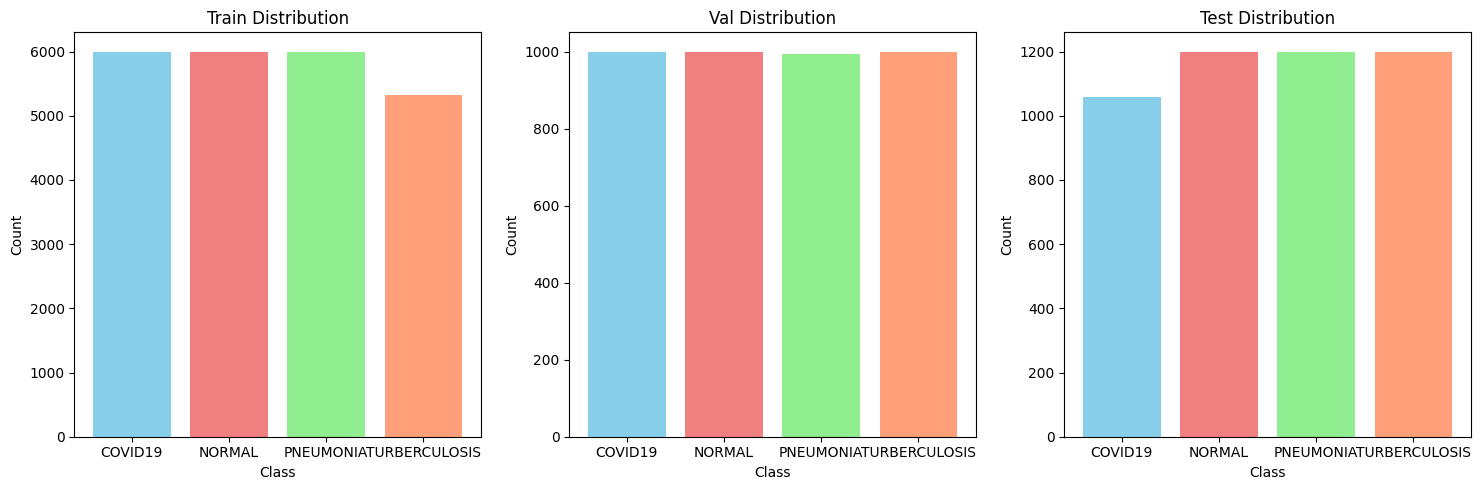

In [36]:
class_counts = {cls: {'train':0, 'val':0, 'test':0} for cls in CLASS_NAMES}
for subset in ['train','val','test']:
    for cls in CLASS_NAMES:
        class_counts[cls][subset] = len(os.listdir(os.path.join(BASE_PATH, subset, cls)))

fig, axs = plt.subplots(1,3, figsize=(15,5))
colors = ['skyblue','lightcoral','lightgreen','lightsalmon']
for i, subset in enumerate(['train','val','test']):
    axs[i].bar(CLASS_NAMES, [class_counts[c][subset] for c in CLASS_NAMES], color=colors)
    axs[i].set_title(f"{subset.capitalize()} Distribution")
    axs[i].set_xlabel('Class'); axs[i].set_ylabel('Count')
plt.tight_layout(); plt.show()

##### 🖼️🔍 Sample Images

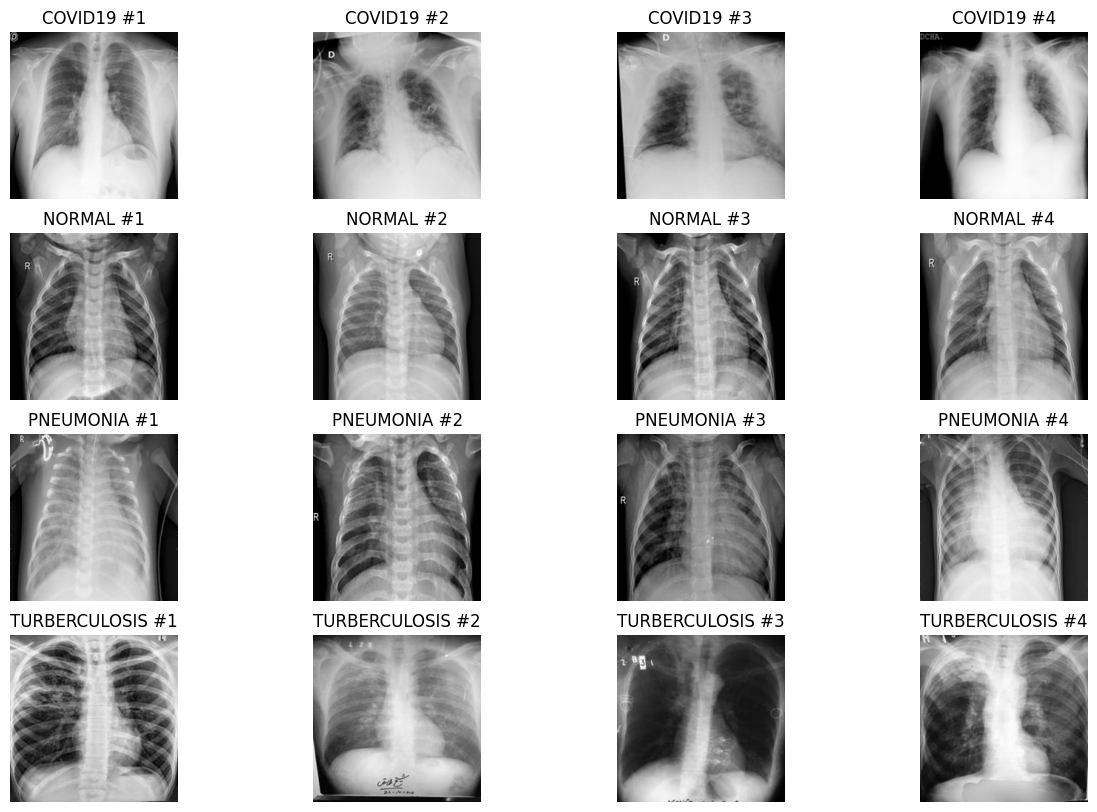

In [37]:
fig, axs = plt.subplots(len(CLASS_NAMES), 4, figsize=(15,10))
for i, cls in enumerate(CLASS_NAMES):
    samples = os.listdir(os.path.join(BASE_PATH, 'train', cls))[:4]
    for j, img_name in enumerate(samples):
        img = mpimg.imread(os.path.join(BASE_PATH, 'train', cls, img_name))
        axs[i,j].imshow(img, cmap='gray'); axs[i,j].axis('off'); axs[i,j].set_title(f"{cls} #{j+1}")
plt.show()

#### 🧹🧪 Data Preparation and Augmentation

In [38]:
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
val_datagen   = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(BASE_PATH, 'train'),
    target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE,
    class_mode='categorical', color_mode='grayscale'
)
val_gen = val_datagen.flow_from_directory(
    os.path.join(BASE_PATH, 'val'),
    target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE,
    class_mode='categorical', color_mode='grayscale'
)

Found 23320 images belonging to 4 classes.
Found 3994 images belonging to 4 classes.


#### 🧠🏗️ Model Definition

In [39]:

# Class names and settings
CLASS_NAMES = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']
num_classes = len(CLASS_NAMES)
img_height, img_width = 150, 150
input_shape = (img_height, img_width, 1)
batch_size = 128
epochs = 50

# Input
inputs = Input(shape=input_shape, name='input_layer')

# CNN Architecture
x = Conv2D(32, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(1e-6))(inputs)
x = MaxPooling2D()(x)
x = Dropout(0.3)(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(1e-6))(x)
x = MaxPooling2D()(x)
x = Dropout(0.3)(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same',
           kernel_regularizer=regularizers.l2(1e-6))(x)
x = MaxPooling2D()(x)
x = Dropout(0.3)(x)

x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-6))(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-6))(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Build model
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │    10,617,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,843,396 (41.36 MB)

 Trainable params: 10,843,396 (41.36 MB)

 Non-trainable params: 0 (0.00 B)

#### ⏱️🔄 Callbacks

In [40]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4),
    ModelCheckpoint(filepath='models/best_model.keras',save_best_only=True),
    TensorBoard(log_dir=LOG_DIR)
]

#### 🏋️‍♂️📈 Training the Model

In [41]:
history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
    callbacks=callbacks
)

c:\Users\abdul\OneDrive\Desktop\myProject\gp\models\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 581s 3s/step - accuracy: 0.4972 - loss: 1.0829 - val_accuracy: 0.7964 - val_loss: 0.5278 - learning_rate: 0.0010
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 566s 3s/step - accuracy: 0.8159 - loss: 0.4792 - val_accuracy: 0.8445 - val_loss: 0.4178 - learning_rate: 0.0010
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 548s 3s/step - accuracy: 0.8541 - loss: 0.3888 - val_accuracy: 0.8746 - val_loss: 0.3491 - learning_rate: 0.0010
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 561s 3s/step - accuracy: 0.8721 - loss: 0.3422 - val_accuracy: 0.8963 - val_loss: 0.2809 - learning_rate: 0.0010
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 560s 3s/step - accuracy: 0.8945 - loss: 0.2845 - val_accuracy: 0.8961 - val_loss: 0.2660 - learning_rate: 0.0010
Epoch 6/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 567s 3s/step - accuracy: 0.9073 - loss: 0.2589 - val_accuracy: 0.9189 - val_loss: 0.2303 - learning_rate: 0.0010
Epoch 7/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 852s 5s/step - accuracy: 0.9116 - loss: 0.

In [42]:
model.save('final_model_o.keras')

In [43]:
# Instead of model.save('model.h5') or 'model.keras'
model.save('best_model.keras', save_format='keras_v3')


In [44]:
model.save('best_model.h5')


#### 💾 Save and Plot Training History

In [46]:
# Convert float32 values to Python float
def convert_to_serializable(obj):
    if isinstance(obj, np.floating):
        return float(obj)
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    if isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    return obj



# Convert history.history and save to JSON
with open(HISTORY_PATH, 'w') as f:
    serializable_history = convert_to_serializable(history.history)
    json.dump(serializable_history, f, indent=4)

#### 🧑‍⚖️📊 Basic Evaluation

##### 📊🔍 Test Set Accuracy Evaluation

In [47]:
# Load the pre-trained model
model = tf.keras.models.load_model(r'C:\Users\abdul\OneDrive\Desktop\myProject\gp\models\models\best_model.keras')

# Load and preprocess test dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(IMG_HEIGHT, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    shuffle=False,
    label_mode='categorical',
    color_mode='grayscale'
)

# Normalize input
normalization_layer = tf.keras.layers.Rescaling(1./255)
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Found 4658 files belonging to 4 classes.
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 245ms/step - accuracy: 0.9618 - loss: 0.1377
Test Accuracy: 93.54%


##### 📈📉 Plot Loss & Accuracy Curves

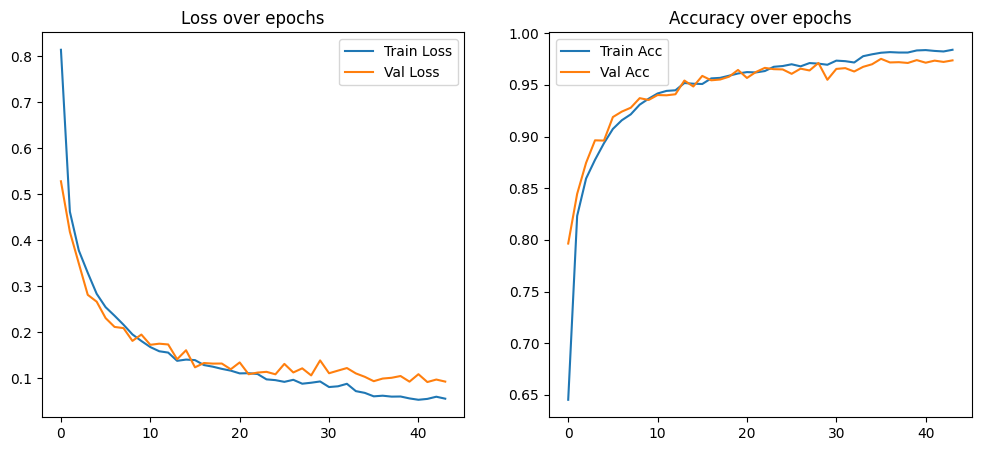

In [48]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs'); plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over epochs'); plt.legend()
plt.show()


#### 📊⚖️ Advanced Evaluation

In [49]:
# Load best model
best_model = load_model(r'C:\Users\abdul\OneDrive\Desktop\myProject\gp\models\models\best_model.keras')

##### 🔥📈 ROC Curve & AUC per Class



Found 3994 files belonging to 4 classes.
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step


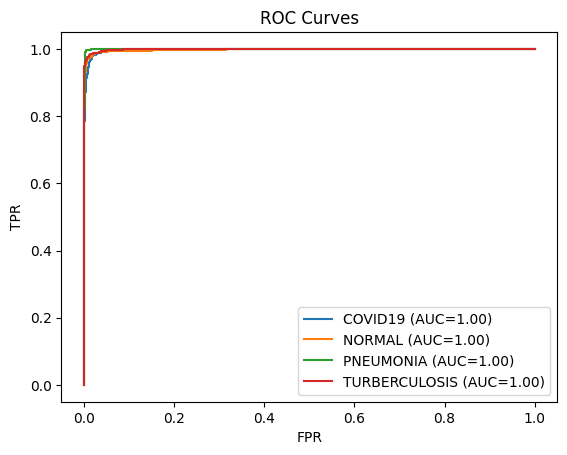

In [50]:
val_dataset = image_dataset_from_directory(
    os.path.join(BASE_PATH,'val'), image_size=(IMG_HEIGHT,IMG_WIDTH), batch_size=BATCH_SIZE,
    label_mode='categorical', color_mode='grayscale', shuffle=False
).map(lambda x,y: (x/255.0,y))

y_true = np.concatenate([y.numpy() for _,y in val_dataset], axis=0)
y_score = best_model.predict(val_dataset)

plt.figure()
for i, cls in enumerate(CLASS_NAMES):
    fpr, tpr, _ = roc_curve(y_true[:,i], y_score[:,i])
    plt.plot(fpr, tpr, label=f'{cls} (AUC={auc(fpr,tpr):.2f})')
plt.title('ROC Curves'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(); plt.show()

##### 📊 Confusion Matrix


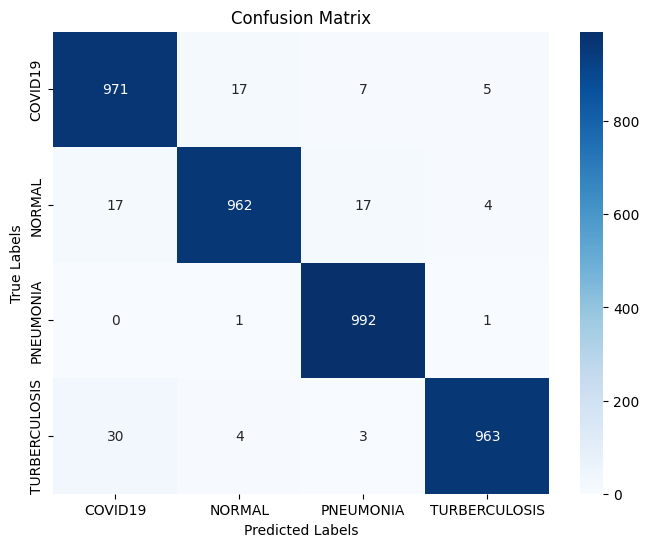

In [51]:
from tensorflow.keras.preprocessing import image

CLASS_NAMES   = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']

# Load the saved model
model_weight = tf.keras.models.load_model(r'C:\Users\abdul\OneDrive\Desktop\myProject\gp\models\models\best_model.keras')

# Predictions and actual labels
predictions = []
labels = []

# Iterate through each class
for class_name in CLASS_NAMES:
    class_path = os.path.join(val_path, class_name)
    
    # Check if the directory exists
    if not os.path.exists(class_path):
        print(f"Directory not found: {class_path}")
        continue
    
    # Iterate through each image
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        
        # Load and resize the image
        img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='grayscale')
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0  # Normalization
        
        # Make a prediction
        prediction = model_weight.predict(img_array, verbose=0)
        predicted_class = np.argmax(prediction, axis=1)[0]
        
        # Add predictions and labels to the lists
        predictions.append(predicted_class)
        labels.append(CLASS_NAMES.index(class_name))

# Create the confusion matrix
cm = confusion_matrix(labels, predictions)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

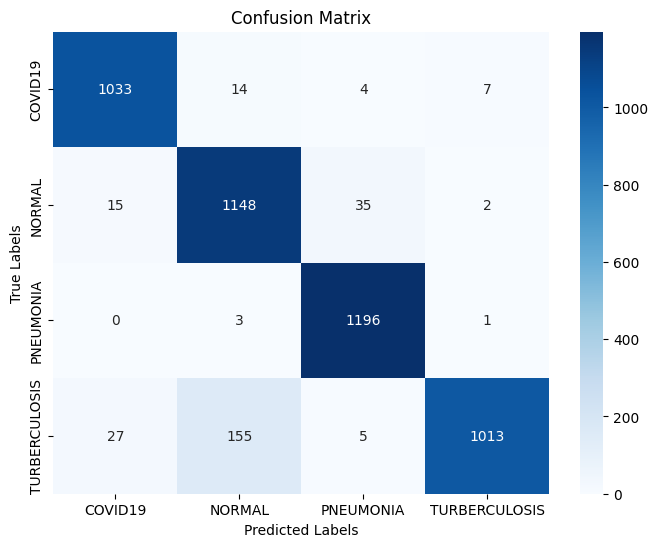

In [52]:
from tensorflow.keras.preprocessing import image

CLASS_NAMES   = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']

# Load the saved model
model_weight = tf.keras.models.load_model(r'C:\Users\abdul\OneDrive\Desktop\myProject\gp\models\models\best_model.keras')

# Predictions and actual labels
predictions = []
labels = []

# Iterate through each class
for class_name in CLASS_NAMES:
    class_path = os.path.join(r'C:\Users\abdul\OneDrive\Desktop\myProject\graduation project\AI-Powered Health Care System\AI-Powered Health Care System\Datasett\test', class_name)
    
    # Check if the directory exists
    if not os.path.exists(class_path):
        print(f"Directory not found: {class_path}")
        continue
    
    # Iterate through each image
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        
        # Load and resize the image
        img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode='grayscale')
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0  # Normalization
        
        # Make a prediction
        prediction = model_weight.predict(img_array, verbose=0)
        predicted_class = np.argmax(prediction, axis=1)[0]
        
        # Add predictions and labels to the lists
        predictions.append(predicted_class)
        labels.append(CLASS_NAMES.index(class_name))

# Create the confusion matrix
cm = confusion_matrix(labels, predictions)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

##### 📑📝 Generate Classification Report

In [53]:
#Predict the classes for the test set
predictions = best_model.predict(val_dataset)

# Get true and predicted labels
y_true = np.argmax(np.concatenate([y for _, y in val_dataset], axis=0), axis=1)
y_pred = np.argmax(predictions, axis=1)

# Generate classification report
report = classification_report(y_true, y_pred, target_names=CLASS_NAMES)
print("\nDetailed Classification Report:")
print(report)

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step

Detailed Classification Report:
               precision    recall  f1-score   support

      COVID19       0.95      0.97      0.96      1000
       NORMAL       0.98      0.96      0.97      1000
    PNEUMONIA       0.97      1.00      0.99       994
TURBERCULOSIS       0.99      0.96      0.97      1000

     accuracy                           0.97      3994
    macro avg       0.97      0.97      0.97      3994
 weighted avg       0.97      0.97      0.97      3994



#### 🧠📸 Grad-CAM Visualization



c:\Users\abdul\OneDrive\Desktop\myProject\gp\models\venv\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 150, 150, 1))
  warnings.warn(msg)


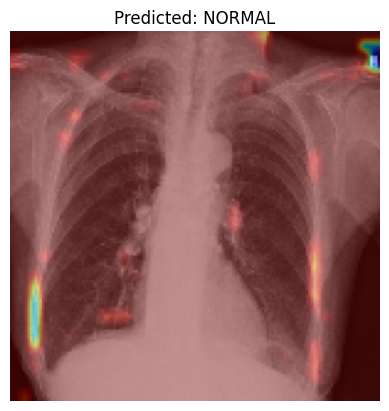

In [54]:


def load_image(image_path, target_size=(150, 150)):
    img = load_img(image_path, color_mode="grayscale", target_size=target_size)
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img, img_array

def get_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("No Conv2D layer found in model.")

def compute_gradcam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        predicted_class = tf.argmax(predictions[0])
        class_output = predictions[:, predicted_class]

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    heatmap = heatmap.numpy()
    return heatmap, predicted_class.numpy()

def superimpose_heatmap(heatmap, original_img, alpha=0.4):
    heatmap = cv2.resize(heatmap, (original_img.size[0], original_img.size[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    original_img = np.array(original_img.convert("RGB"))
    superimposed_img = cv2.addWeighted(original_img, 1 - alpha, heatmap_color, alpha, 0)
    return superimposed_img

def gradcam_visualization(model_path, image_path):
    model = load_model(model_path)
    target_size = (150, 150)

    original_img, img_array = load_image(image_path, target_size)
    last_conv_layer_name = get_last_conv_layer(model)
    heatmap, predicted_class = compute_gradcam(model, img_array, last_conv_layer_name)

    superimposed_img = superimpose_heatmap(heatmap, original_img)

    plt.imshow(superimposed_img)
    plt.title(f"Predicted: {CLASS_NAMES[predicted_class]}")
    plt.axis("off")
    plt.show()

# Example usage
model_path = r'C:\Users\abdul\OneDrive\Desktop\myProject\gp\models\models\best_model.keras'
image_path = r"C:\Users\abdul\OneDrive\Desktop\myProject\graduation project\AI-Powered Health Care System\AI-Powered Health Care System\Dataset\Chest-x-ray\tbj.jpeg"
gradcam_visualization(model_path, image_path)